In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y8a1gram
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y8a1gram
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 928.8 kB/s eta 0:00:000:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=aef8a1a856350d07a2bd5f998e5fff1a6af7fe20355c67a845577dadd59c2aa6
  Stored in directory: /tmp/pip-ephem-wheel-cache-oimgl2oj/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


<h1><u>Question-2</u></h1>

<h3>PART-1</h3>

* We first load in the instances of the ResNET and CLIP models.
* The ResNet-50 model has been pretrained on the ImageNet dataset.
* The CLIP model also used the ResNet-50 model as its visual encoder. However, their architectures will not be the exact same. This is because CLIP's visual encoder is trained in conjunction with a text encoder to understand the relationship between images and text. Thus, the ResNet-50 model used here will be such that its input and output has been optimised for the CLIP architecture. 
* The difference in their architecture is also made clear when we print the number of parameters for each model instance. 

CLIP = 38316896 <br>
R-50 = 25557032



In [2]:
import torch
import torchvision.models as models
from torchvision import transforms
import clip
import gc
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Load ResNet-50 model with ImageNet pretraining
resnet50_imagenet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50_imagenet.eval()
resnet50_imagenet.to('cuda')

clip_model, _ = clip.load("RN50")
clip_model.eval()
clip_model.to('cuda')
clip_visual_encoder = clip_model.visual

cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s] 
100%|███████████████████████████████████████| 244M/244M [00:02<00:00, 86.3MiB/s]


In [6]:
clip_params = sum(p.numel() for p in clip_visual_encoder.parameters())
print(clip_params)

r50_params = sum(p.numel() for p in resnet50_imagenet.parameters())
print(r50_params)

38316896
25557032


<h3>PART-2</h3>

1. The ImageNet challenge uses a label hierarchy that is based on the WordNet hierarchy. Essential, images that are based on synonyms/similar concepts (also called synsets) are grouped together. Thus, the synsets are organised in a hierarchial structure based on hypernyms and hyponyms - they start from broad categories such as "animal" and narrow down to specific categories like "dog"."

2. A synset stands for 'synonym set' and it is a group of words that represent the same/similar conecpt. In ImageNet, each synset is a set of images representing the concept or object described by the synset. For example, the synset for "dog" includes various breeds of dogs.

3. There are likely some problems that could arise when we group based on synsets:
* There could be a lot of intra-class variability as objects within the same synset (for example cars) could vary in colour, size, shape etc.
* Eventhough two objects belong to different synsets, they could have similar characteristics (for example breeds of dogs) leading to inter-class similarity.

4. Objects within the same synset could also have visual differences:
* The object could be in different oritentations or positions.
* The illumination and camera perspective also will not be constant and could change within a synset.
* Finally, the background variations will also vary how the object is percieved.


In [16]:
categories = "/kaggle/input/labels/imagenet1000_clsidx_to_labels.txt" 
with open(categories, 'r') as file:
    imagenet_categories = [line.strip() for line in file]

text_labels = []
for text in imagenet_categories:
    text = text.strip().strip('{}').strip(",")
    key, value = text.split(': ')
    value = value.strip().strip("'")
    first_word = value.split(',')[0]
    text_labels.append(first_word)

text_features = []
num_categories = len(text_labels)
for i in range(0, 10):
    category = text_labels[i]
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {category}")])
    text_inputs = text_inputs.to('cuda')
    text_feature = clip_model.encode_text(text_inputs)
    text_features.append(text_feature)

text_features = torch.cat(text_features)
print(text_features)

tensor([[-0.0342,  0.3015, -0.2695,  ..., -0.0099,  0.0071,  0.2280],
        [-0.0453,  0.2852, -0.2072,  ...,  0.1058, -0.0051,  0.3496],
        [-0.0190,  0.2472, -0.4221,  ...,  0.2705, -0.0704,  0.2141],
        ...,
        [ 0.0746, -0.0352, -0.1093,  ...,  0.0179, -0.5039,  0.0597],
        [ 0.1315,  0.2350,  0.2086,  ..., -0.1317, -0.5542,  0.2058],
        [ 0.1450,  0.1091,  0.0055,  ...,  0.1110, -0.1796,  0.1787]],
       device='cuda:0', dtype=torch.float16, grad_fn=<CatBackward0>)


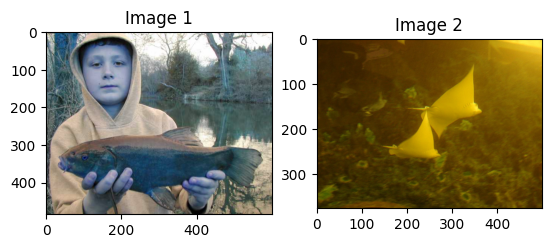

In [17]:
image_paths = ["/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01440764/n01440764_15071.JPEG", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01496331/n01496331_18272.JPEG"]

transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        plt.subplot(1,2,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        i+=1

        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)

    
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

<h3><u> PART-3 </u></h3>

* We test out the CLIP model on two images from the ImageNet dataset.
* The cosine similarities of the image features and the text features are computed and then a softmax function is applied to it to retirieve the corresponding probabilities. 
* The model is correctly able to correlate the image to the text encoding. 

In [18]:
cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)

for i, prob in enumerate(probabilities):
    max_index = prob.argmax().item()
    predicted_category = text_labels[max_index]
    print(f"Image {i + 1} is predicted to be in category: {predicted_category}")

Image 1 is predicted to be in category: tench
Image 2 is predicted to be in category: stingray


In [19]:
labels_ten = [text_labels[22], text_labels[29], text_labels[39], text_labels[63], text_labels[84], text_labels[71], text_labels[79], text_labels[100], text_labels[245], text_labels[288]]
print(labels_ten)
print(len(labels_ten))

['bald eagle', 'axolotl', 'common iguana', 'Indian cobra', 'peacock', 'scorpion', 'centipede', 'black swan', 'French bulldog', 'leopard']
10


<h3><u> PART-4 </u></h3>

* 10 different imagenet classes have been considered: ['bald eagle', 'axolotl', 'common iguana', 'Indian cobra', 'peacock', 'scorpion', 'centipede', 'black swan', 'French bulldog', 'leopard']

* Images from all these classes have been tested on both models to compare their performance.


* We notice that the CLIP model performs much better than the ResNet one at images from the ImageNet Sketch and ImageNet-r datasets. Thus, the CLIP model is much more robust to dristribution shifts than a generic ImageNet model. CLIP’s zero-shot learning ability allows it to generalize across various tasks and datasets without needing specific training for each one (because it correlates the text encodings and image encodings without having to rely on learning the image features)

* The ImageNet trained ResNet will perform better than CLIP if it is given images directly from the ImageNet dataset. However, this difference is very minute and CLIP performs on par with the ResNet model. 

<h3> Bald Eagle </h3>

<u>ResNet 50:</u>

Top 5 matches with ResNet for image 1:
Class: quill, Probability: 0.2188
Class: ladle, Probability: 0.0367
Class: nematode, Probability: 0.0244
Class: trilobite, Probability: 0.0186
Class: chambered nautilus, Probability: 0.0184


Top 5 matches with ResNet for image 2:
Class: trilobite, Probability: 0.1443
Class: wooden spoon, Probability: 0.0232
Class: goblet, Probability: 0.0198
Class: mask, Probability: 0.0196
Class: soap dispenser, Probability: 0.0193


Top 5 matches with ResNet for image 3:
Class: bald eagle, Probability: 0.9265
Class: vulture, Probability: 0.0169
Class: kite, Probability: 0.0129
Class: pelican, Probability: 0.0070
Class: black swan, Probability: 0.0056




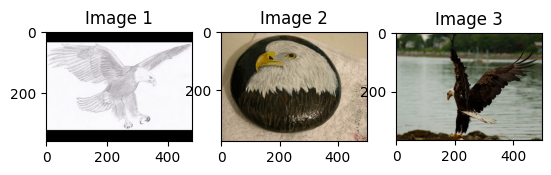

In [20]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01614925/sketch_2.JPEG", "/kaggle/input/baldeagle/art_6.jpg", "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01614925/n01614925_10607.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP:</u>

In [21]:
text_features = []
for i in range(0, 10):
    category = labels_ten[i]
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {category}")])
    text_inputs = text_inputs.to('cuda')
    text_feature = clip_model.encode_text(text_inputs)
    text_features.append(text_feature)

text_features = torch.cat(text_features)


Top 5 matches with CLIP for image {i+1}:
  Class: bald eagle, Similarity: 0.1075
  Class: peacock, Similarity: 0.1024
  Class: scorpion, Similarity: 0.1021
  Class: black swan, Similarity: 0.1005
  Class: axolotl, Similarity: 0.0994


  Class: bald eagle, Similarity: 0.1127
  Class: black swan, Similarity: 0.1000
  Class: peacock, Similarity: 0.0997
  Class: Indian cobra, Similarity: 0.0997
  Class: centipede, Similarity: 0.0996


  Class: bald eagle, Similarity: 0.1122
  Class: black swan, Similarity: 0.1059
  Class: peacock, Similarity: 0.1034
  Class: scorpion, Similarity: 0.1017
  Class: Indian cobra, Similarity: 0.0984




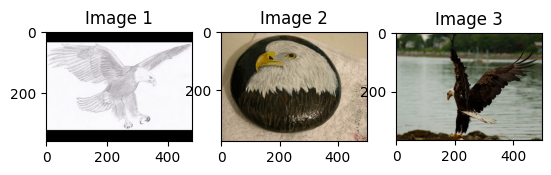

In [22]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

print("\nTop 5 matches with CLIP for image {i+1}:")
for i, top5 in enumerate(clip_top5):
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h3> Axolotl </h3>

<u>ResNet 50:</u>

Top 5 matches with ResNet for image 1:
Class: quill, Probability: 0.0234
Class: nematode, Probability: 0.0199
Class: hook, Probability: 0.0196
Class: letter opener, Probability: 0.0137
Class: hair slide, Probability: 0.0126


Top 5 matches with ResNet for image 2:
Class: hair slide, Probability: 0.0807
Class: hook, Probability: 0.0240
Class: necklace, Probability: 0.0182
Class: plate, Probability: 0.0179
Class: candle, Probability: 0.0141


Top 5 matches with ResNet for image 3:
Class: axolotl, Probability: 0.9992
Class: common newt, Probability: 0.0004
Class: banded gecko, Probability: 0.0002
Class: tailed frog, Probability: 0.0000
Class: goldfish, Probability: 0.0000




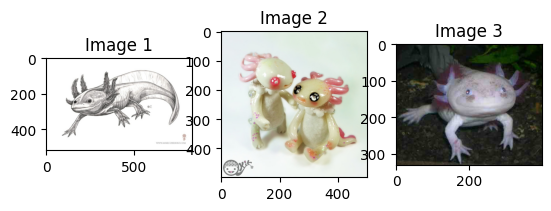

In [23]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01632777/sketch_17.JPEG", "/kaggle/input/baldeagle/art_7.jpg", "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01632777/n01632777_10179.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")


Top 5 matches with CLIP for image 1:
  Class: axolotl, Similarity: 0.1088
  Class: common iguana, Similarity: 0.1063
  Class: scorpion, Similarity: 0.1024
  Class: centipede, Similarity: 0.1010
  Class: peacock, Similarity: 0.0986



Top 5 matches with CLIP for image 2:
  Class: axolotl, Similarity: 0.1085
  Class: centipede, Similarity: 0.1036
  Class: scorpion, Similarity: 0.1017
  Class: French bulldog, Similarity: 0.1016
  Class: black swan, Similarity: 0.0986



Top 5 matches with CLIP for image 3:
  Class: axolotl, Similarity: 0.1171
  Class: common iguana, Similarity: 0.1029
  Class: French bulldog, Similarity: 0.1020
  Class: centipede, Similarity: 0.1005
  Class: scorpion, Similarity: 0.0997




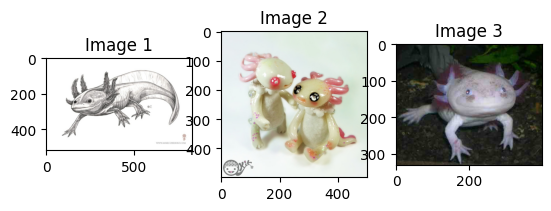

In [24]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Common Iguana</h4>
<u>RESNET</u>

Top 5 matches with ResNet for image 1:
Class: quill, Probability: 0.1046
Class: common iguana, Probability: 0.0198
Class: ladle, Probability: 0.0161
Class: corkscrew, Probability: 0.0154
Class: can opener, Probability: 0.0126


Top 5 matches with ResNet for image 2:
Class: common iguana, Probability: 0.8188
Class: frilled lizard, Probability: 0.0472
Class: triceratops, Probability: 0.0379
Class: African chameleon, Probability: 0.0163
Class: whiptail, Probability: 0.0107


Top 5 matches with ResNet for image 3:
Class: common iguana, Probability: 0.9468
Class: Komodo dragon, Probability: 0.0216
Class: whiptail, Probability: 0.0058
Class: green lizard, Probability: 0.0047
Class: alligator lizard, Probability: 0.0036




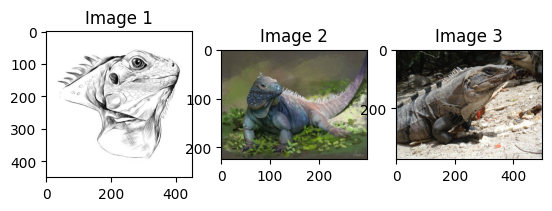

In [25]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01677366/sketch_14.JPEG", "/kaggle/input/baldeagle/deviantart_17.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01677366/n01677366_1884.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    image = image.convert("RGB")
    
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: common iguana, Similarity: 0.1094
  Class: axolotl, Similarity: 0.1014
  Class: leopard, Similarity: 0.1008
  Class: scorpion, Similarity: 0.1007
  Class: peacock, Similarity: 0.1005



Top 5 matches with CLIP for image 2:
  Class: common iguana, Similarity: 0.1075
  Class: axolotl, Similarity: 0.1055
  Class: scorpion, Similarity: 0.1026
  Class: centipede, Similarity: 0.1008
  Class: French bulldog, Similarity: 0.0991



Top 5 matches with CLIP for image 3:
  Class: common iguana, Similarity: 0.1144
  Class: scorpion, Similarity: 0.1018
  Class: axolotl, Similarity: 0.0999
  Class: centipede, Similarity: 0.0995
  Class: peacock, Similarity: 0.0993




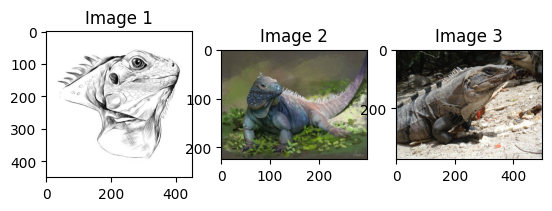

In [26]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Indian Cobra</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: nematode, Probability: 0.0697
Class: Indian cobra, Probability: 0.0652
Class: hook, Probability: 0.0168
Class: alligator lizard, Probability: 0.0153
Class: eel, Probability: 0.0144


Top 5 matches with ResNet for image 2:
Class: mouse, Probability: 0.0815
Class: tray, Probability: 0.0455
Class: CD player, Probability: 0.0455
Class: pencil sharpener, Probability: 0.0397
Class: comic book, Probability: 0.0370


Top 5 matches with ResNet for image 3:
Class: Indian cobra, Probability: 0.4546
Class: sidewinder, Probability: 0.0963
Class: horned viper, Probability: 0.0767
Class: night snake, Probability: 0.0416
Class: diamondback, Probability: 0.0390




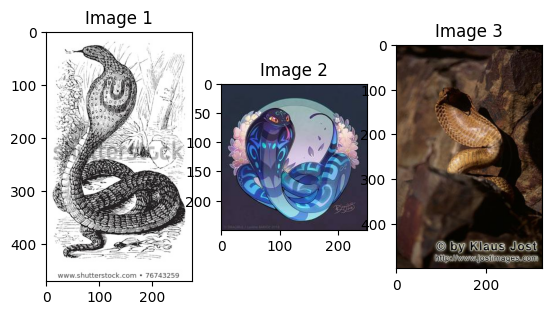

In [27]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01748264/sketch_23.JPEG", "/kaggle/input/baldeagle/deviantart_7.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01748264/n01748264_1664.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: Indian cobra, Similarity: 0.1071
  Class: peacock, Similarity: 0.1013
  Class: black swan, Similarity: 0.1012
  Class: common iguana, Similarity: 0.1012
  Class: scorpion, Similarity: 0.1011



Top 5 matches with CLIP for image 2:
  Class: black swan, Similarity: 0.1047
  Class: Indian cobra, Similarity: 0.1030
  Class: peacock, Similarity: 0.1014
  Class: centipede, Similarity: 0.1008
  Class: scorpion, Similarity: 0.1008



Top 5 matches with CLIP for image 3:
  Class: Indian cobra, Similarity: 0.1115
  Class: scorpion, Similarity: 0.1062
  Class: common iguana, Similarity: 0.1021
  Class: centipede, Similarity: 0.1019
  Class: leopard, Similarity: 0.0999




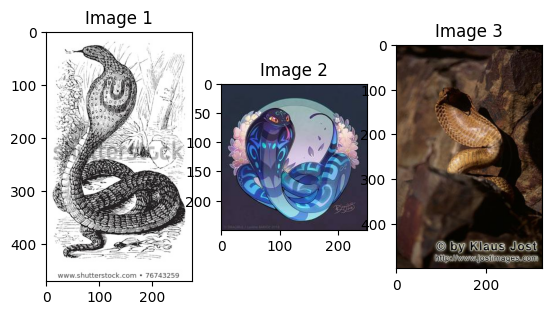

In [28]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Peacock</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: envelope, Probability: 0.2266
Class: binder, Probability: 0.0960
Class: shower curtain, Probability: 0.0574
Class: tray, Probability: 0.0204
Class: quill, Probability: 0.0200


Top 5 matches with ResNet for image 2:
Class: umbrella, Probability: 0.0814
Class: coil, Probability: 0.0653
Class: confectionery, Probability: 0.0573
Class: greenhouse, Probability: 0.0403
Class: safety pin, Probability: 0.0289


Top 5 matches with ResNet for image 3:
Class: peacock, Probability: 0.9016
Class: lawn mower, Probability: 0.0066
Class: drake, Probability: 0.0040
Class: cock, Probability: 0.0033
Class: hen, Probability: 0.0026




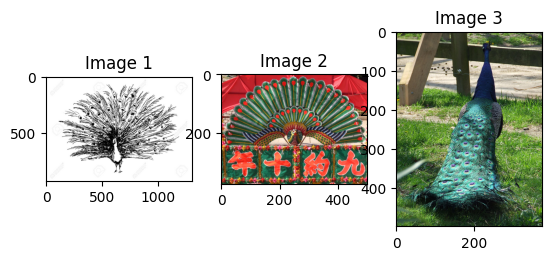

In [30]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01806143/sketch_19.JPEG", "/kaggle/input/baldeagle/art_3.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01806143/n01806143_6599.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    image = image.convert("RGB")
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: peacock, Similarity: 0.1072
  Class: bald eagle, Similarity: 0.1030
  Class: black swan, Similarity: 0.1022
  Class: axolotl, Similarity: 0.1021
  Class: centipede, Similarity: 0.1011



Top 5 matches with CLIP for image 2:
  Class: peacock, Similarity: 0.1066
  Class: centipede, Similarity: 0.1035
  Class: scorpion, Similarity: 0.1000
  Class: common iguana, Similarity: 0.1000
  Class: black swan, Similarity: 0.0997



Top 5 matches with CLIP for image 3:
  Class: peacock, Similarity: 0.1134
  Class: common iguana, Similarity: 0.1010
  Class: bald eagle, Similarity: 0.1005
  Class: black swan, Similarity: 0.1005
  Class: leopard, Similarity: 0.0992




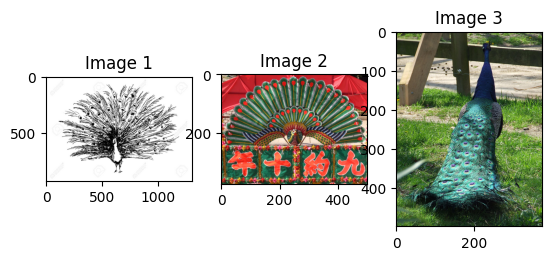

In [31]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Centipede</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: trilobite, Probability: 0.3621
Class: centipede, Probability: 0.2295
Class: "spider web, Probability: 0.0535
Class: isopod, Probability: 0.0497
Class: barn spider, Probability: 0.0251


Top 5 matches with ResNet for image 2:
Class: sea anemone, Probability: 0.1142
Class: centipede, Probability: 0.0708
Class: doormat, Probability: 0.0531
Class: sea snake, Probability: 0.0381
Class: lionfish, Probability: 0.0241


Top 5 matches with ResNet for image 3:
Class: centipede, Probability: 0.7817
Class: scorpion, Probability: 0.0503
Class: wolf spider, Probability: 0.0201
Class: harvestman, Probability: 0.0176
Class: isopod, Probability: 0.0162




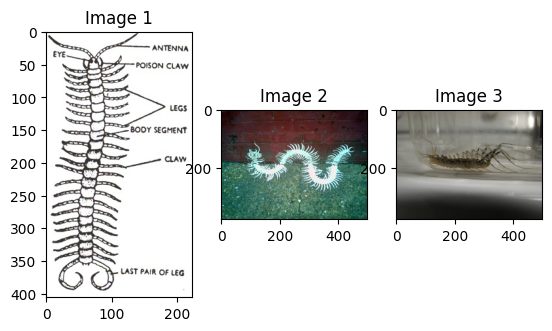

In [33]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01784675/sketch_24.JPEG", "/kaggle/input/baldeagle/graffiti_0.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01784675/n01784675_21526.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: centipede, Similarity: 0.1065
  Class: scorpion, Similarity: 0.1026
  Class: common iguana, Similarity: 0.1010
  Class: bald eagle, Similarity: 0.1010
  Class: peacock, Similarity: 0.0997



Top 5 matches with CLIP for image 2:
  Class: centipede, Similarity: 0.1091
  Class: scorpion, Similarity: 0.1058
  Class: axolotl, Similarity: 0.1030
  Class: black swan, Similarity: 0.1017
  Class: Indian cobra, Similarity: 0.1000



Top 5 matches with CLIP for image 3:
  Class: centipede, Similarity: 0.1088
  Class: scorpion, Similarity: 0.1085
  Class: common iguana, Similarity: 0.1019
  Class: axolotl, Similarity: 0.1008
  Class: peacock, Similarity: 0.0991




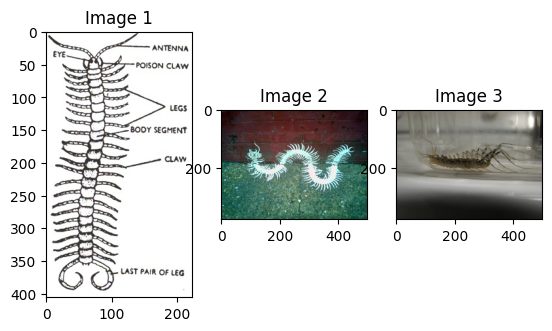

In [34]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Black Swan</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: envelope, Probability: 0.0493
Class: nematode, Probability: 0.0226
Class: chain, Probability: 0.0177
Class: shovel, Probability: 0.0129
Class: nail, Probability: 0.0125


Top 5 matches with ResNet for image 2:
Class: hook, Probability: 0.0562
Class: book jacket, Probability: 0.0397
Class: black swan, Probability: 0.0179
Class: envelope, Probability: 0.0159
Class: Indian cobra, Probability: 0.0135


Top 5 matches with ResNet for image 3:
Class: black swan, Probability: 0.8496
Class: flamingo, Probability: 0.0142
Class: American alligator, Probability: 0.0117
Class: goose, Probability: 0.0107
Class: drake, Probability: 0.0106




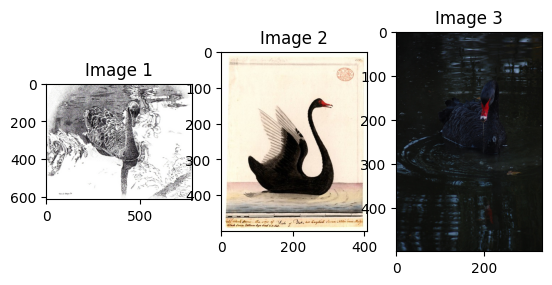

In [35]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01860187/sketch_20.JPEG", "/kaggle/input/baldeagle/art_1.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01860187/n01860187_375.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: black swan, Similarity: 0.1042
  Class: peacock, Similarity: 0.1041
  Class: bald eagle, Similarity: 0.1015
  Class: common iguana, Similarity: 0.1006
  Class: scorpion, Similarity: 0.1005



Top 5 matches with CLIP for image 2:
  Class: black swan, Similarity: 0.1101
  Class: peacock, Similarity: 0.1021
  Class: bald eagle, Similarity: 0.1015
  Class: scorpion, Similarity: 0.1014
  Class: Indian cobra, Similarity: 0.1010



Top 5 matches with CLIP for image 3:
  Class: black swan, Similarity: 0.1172
  Class: peacock, Similarity: 0.1052
  Class: bald eagle, Similarity: 0.1035
  Class: centipede, Similarity: 0.0974
  Class: Indian cobra, Similarity: 0.0974




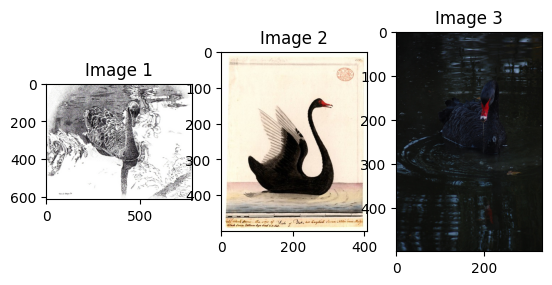

In [36]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>French Bulldog</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: hook, Probability: 0.0351
Class: nail, Probability: 0.0343
Class: hair slide, Probability: 0.0321
Class: safety pin, Probability: 0.0224
Class: paintbrush, Probability: 0.0188


Top 5 matches with ResNet for image 2:
Class: French bulldog, Probability: 0.0758
Class: muzzle, Probability: 0.0531
Class: Boston bull, Probability: 0.0474
Class: Chihuahua, Probability: 0.0465
Class: rhinoceros beetle, Probability: 0.0388


Top 5 matches with ResNet for image 3:
Class: French bulldog, Probability: 0.0557
Class: Boston bull, Probability: 0.0315
Class: window screen, Probability: 0.0189
Class: doormat, Probability: 0.0181
Class: bookcase, Probability: 0.0177




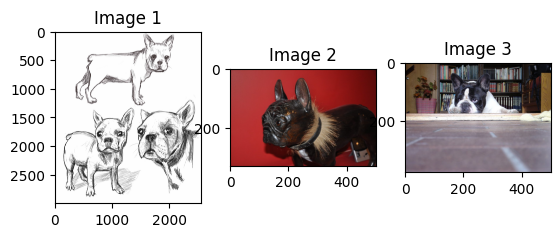

In [37]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n02108915/sketch_19.JPEG", "/kaggle/input/baldeagle/misc_25.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n02108915/n02108915_2118.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: French bulldog, Similarity: 0.1152
  Class: leopard, Similarity: 0.1012
  Class: scorpion, Similarity: 0.1003
  Class: centipede, Similarity: 0.1002
  Class: common iguana, Similarity: 0.0998



Top 5 matches with CLIP for image 2:
  Class: French bulldog, Similarity: 0.1101
  Class: scorpion, Similarity: 0.1017
  Class: centipede, Similarity: 0.1007
  Class: bald eagle, Similarity: 0.0999
  Class: common iguana, Similarity: 0.0995



Top 5 matches with CLIP for image 3:
  Class: French bulldog, Similarity: 0.1126
  Class: scorpion, Similarity: 0.1017
  Class: common iguana, Similarity: 0.1003
  Class: leopard, Similarity: 0.0994
  Class: centipede, Similarity: 0.0994




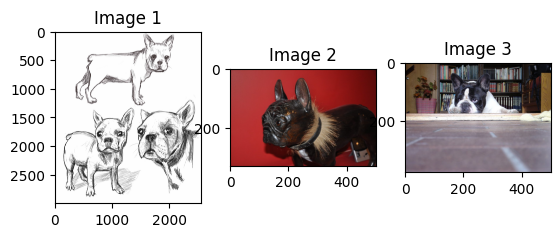

In [38]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Leopard</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: cheetah, Probability: 0.1113
Class: snow leopard, Probability: 0.0417
Class: tabby, Probability: 0.0346
Class: tiger, Probability: 0.0308
Class: tiger cat, Probability: 0.0237


Top 5 matches with ResNet for image 2:
Class: teddy, Probability: 0.0857
Class: pillow, Probability: 0.0352
Class: velvet, Probability: 0.0226
Class: bow tie, Probability: 0.0213
Class: hair slide, Probability: 0.0181


Top 5 matches with ResNet for image 3:
Class: leopard, Probability: 0.7159
Class: jaguar, Probability: 0.2170
Class: snow leopard, Probability: 0.0121
Class: cheetah, Probability: 0.0112
Class: tiger cat, Probability: 0.0038




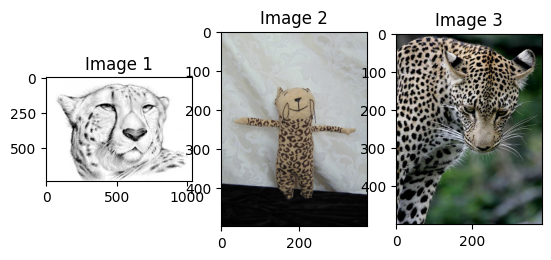

In [39]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n02128385/sketch_12.JPEG", "/kaggle/input/baldeagle/embroidery_2.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n02128385/n02128385_2965.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP</u>


Top 5 matches with CLIP for image 1:
  Class: leopard, Similarity: 0.1097
  Class: common iguana, Similarity: 0.1017
  Class: scorpion, Similarity: 0.1010
  Class: bald eagle, Similarity: 0.1005
  Class: French bulldog, Similarity: 0.0997



Top 5 matches with CLIP for image 2:
  Class: leopard, Similarity: 0.1049
  Class: scorpion, Similarity: 0.1014
  Class: centipede, Similarity: 0.1012
  Class: axolotl, Similarity: 0.1011
  Class: bald eagle, Similarity: 0.1011



Top 5 matches with CLIP for image 3:
  Class: leopard, Similarity: 0.1135
  Class: Indian cobra, Similarity: 0.1013
  Class: common iguana, Similarity: 0.1004
  Class: bald eagle, Similarity: 0.1003
  Class: scorpion, Similarity: 0.0997




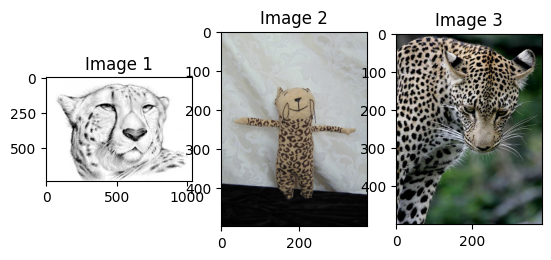

In [40]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h4>Scorpion</h4>
<u>ResNET</u>

Top 5 matches with ResNet for image 1:
Class: envelope, Probability: 0.0811
Class: hook, Probability: 0.0498
Class: nematode, Probability: 0.0380
Class: whistle, Probability: 0.0276
Class: binder, Probability: 0.0215


Top 5 matches with ResNet for image 2:
Class: ant, Probability: 0.0528
Class: trilobite, Probability: 0.0414
Class: centipede, Probability: 0.0382
Class: sea snake, Probability: 0.0335
Class: megalith, Probability: 0.0308


Top 5 matches with ResNet for image 3:
Class: scorpion, Probability: 0.3824
Class: isopod, Probability: 0.0159
Class: crayfish, Probability: 0.0126
Class: rock crab, Probability: 0.0122
Class: honeycomb, Probability: 0.0112




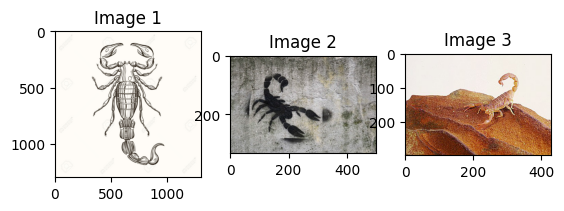

In [41]:
image_paths = ["/kaggle/input/imagenetsketch/sketch/n01770393/sketch_33.JPEG", "/kaggle/input/baldeagle/art_0.jpg", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01770393/n01770393_7489.JPEG"]

plt.figure()
i = 0
for image_path in image_paths:
    image = Image.open(image_path)
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    
    transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image =  transform(image)
    image = image.unsqueeze(0)
    image = image.to('cuda')
    
    resnet_outputs = resnet50_imagenet(image)
    temp, resnet_top5 = torch.topk(resnet_outputs, k=5, dim=1)
    resnet_top5 = resnet_top5.squeeze().cpu().numpy()
    
    print(f"Top 5 matches with ResNet for image {i+1}:")
    for idx in resnet_top5:
        print(f"Class: {text_labels[idx]}, Probability: {torch.softmax(resnet_outputs, dim=1).squeeze()[idx]:.4f}")
    i += 1
    print("\n")

<u>CLIP<u>


Top 5 matches with CLIP for image 1:
  Class: scorpion, Similarity: 0.1107
  Class: centipede, Similarity: 0.1085
  Class: common iguana, Similarity: 0.1022
  Class: axolotl, Similarity: 0.1022
  Class: Indian cobra, Similarity: 0.1010



Top 5 matches with CLIP for image 2:
  Class: scorpion, Similarity: 0.1053
  Class: black swan, Similarity: 0.1022
  Class: centipede, Similarity: 0.1016
  Class: common iguana, Similarity: 0.0994
  Class: bald eagle, Similarity: 0.0991



Top 5 matches with CLIP for image 3:
  Class: scorpion, Similarity: 0.1110
  Class: common iguana, Similarity: 0.1068
  Class: centipede, Similarity: 0.1054
  Class: axolotl, Similarity: 0.1031
  Class: Indian cobra, Similarity: 0.1015




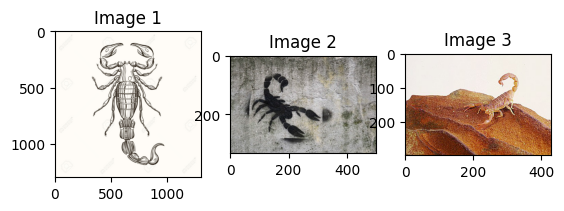

In [42]:
transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = clip_model.encode_image(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

<h3><u>PART-5</u></h3>

* To convert the visual encoder model to fp16, we half the inputs and the parameters in the model. 
* The difference between the fp32 and fp16 models is apparent from the mean and standard deviation computed. 

FP32 mean inference time: 0.0087s, std dev: 0.0008s<br>
FP16 mean inference time: 0.0085s, std dev: 0.0003s

* Thus, we see that the fp16 does take lesser time to run. It's lower standard deviation also indicates that it is stable and consistent 

In [49]:
import time
import numpy as np

image_path = "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_11113.JPEG"

image = cv.imread(image_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = Image.fromarray(image)
image_tensor = _(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')


clip_visual = clip_model.visual
clip_visual.to('cuda')
fp16 = clip_visual.half()
fp16.to('cuda')

times = []
for i in range(100):
    start_time = time.time()
    with torch.no_grad():
        output = fp16(image_tensor)
    times.append(time.time() - start_time)
mean_fp16 = np.mean(times)
std_fp16 = np.std(times)
# sum([(x - mean_time) ** 2 for x in times])
# std_dev_time = (summation/100) ** 0.5

times = []
for i in range(100):
    start_time = time.time()
    with torch.no_grad():
        output = clip_visual(image_tensor)
    times.append(time.time() - start_time)
mean_fp32 = np.mean(times)
std_fp32 = np.std(times)

print(f"FP32 mean inference time: {mean_fp32:.4f} s, std dev: {std_fp32:.4f} s")
print(f"FP16 mean inference time: {mean_fp16:.4f}s, std dev: {std_fp16:.4f}s")


FP32 mean inference time: 0.0087 s, std dev: 0.0008 s
FP16 mean inference time: 0.0085s, std dev: 0.0003s


* The top 5 rankings for both the fp16 and fp32 model are the same. However, we do notice a difference in the probability scores. This difference can be attributed to the fact that the fp32 model will be more accurate. 

* However, we can see that the accuracy for the fp16 model is not very bad and it still computes the correct class for the corresponding images. Hence, there is a good trade-off between the memory saved and accuracy.


Top 5 matches with CLIP for image 1:
  Class: scorpion, Similarity: 0.1110
  Class: common iguana, Similarity: 0.1068
  Class: centipede, Similarity: 0.1054
  Class: axolotl, Similarity: 0.1031
  Class: Indian cobra, Similarity: 0.1015



Top 5 matches with CLIP for image 2:
  Class: centipede, Similarity: 0.1088
  Class: scorpion, Similarity: 0.1085
  Class: common iguana, Similarity: 0.1019
  Class: axolotl, Similarity: 0.1008
  Class: peacock, Similarity: 0.0991



Top 5 matches with CLIP for image 3:
  Class: peacock, Similarity: 0.1134
  Class: common iguana, Similarity: 0.1010
  Class: black swan, Similarity: 0.1005
  Class: bald eagle, Similarity: 0.1005
  Class: leopard, Similarity: 0.0992



Top 5 matches with CLIP for image 4:
  Class: Indian cobra, Similarity: 0.1115
  Class: scorpion, Similarity: 0.1061
  Class: common iguana, Similarity: 0.1021
  Class: centipede, Similarity: 0.1019
  Class: black swan, Similarity: 0.0999



Top 5 matches with CLIP for image 5:
  Class: a

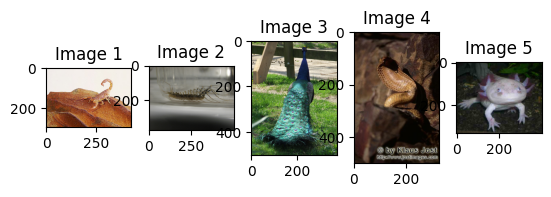

In [51]:
image_paths = ["/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01770393/n01770393_7489.JPEG", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01784675/n01784675_21526.JPEG", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01806143/n01806143_6599.JPEG", "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01748264/n01748264_1664.JPEG", "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01632777/n01632777_10179.JPEG"]

transformed_images = []
plt.figure()
i = 0
for image_path in image_paths:
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.subplot(1,5,i+1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        
        image = Image.fromarray(image)
        image_tensor = _(image)
        image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to('cuda')
        transformed_images.append(image_tensor)   
        i+=1
    
images_tensor = torch.cat(transformed_images)
image_features = fp16(images_tensor)

cosine_similarities = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=2)
probabilities = torch.nn.functional.softmax(cosine_similarities, dim=1)
clip_top5 = torch.topk(probabilities, k=5, dim=1).indices.squeeze().cpu().numpy()

for i, top5 in enumerate(clip_top5):
    print(f"\nTop 5 matches with fp16 CLIP for image {i+1}:")
    for idx in top5:
        print(f"  Class: {labels_ten[idx]}, Similarity: {probabilities[i, idx]:.4f}")
    print("\n")

* Using the pytorch memory usage function, we see that the forward pass of the fp16 model uses significantly less memory than the fp32 mdoel. This is because it is not as computationally expensive and also uses lesser number of bits (16-bit floating point numbers).

In [52]:
image_path = "/kaggle/input/imagenetmini-1000/imagenet-mini/train/n01518878/n01518878_11113.JPEG"

image = cv.imread(image_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = Image.fromarray(image)
image_tensor = _(image)
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to('cuda')

In [65]:
torch.cuda.reset_peak_memory_stats()

torch.cuda.memory._record_memory_history(max_entries=100000)
output = fp16(image_tensor)
torch.cuda.memory._dump_snapshot("fp16-model")

torch.cuda.memory._record_memory_history(enabled=None)

In [63]:
torch.cuda.reset_peak_memory_stats()

torch.cuda.memory._record_memory_history(max_entries=100000)
output = clip_visual(image_tensor)
torch.cuda.memory._dump_snapshot("fp32-model")

torch.cuda.memory._record_memory_history(enabled=None)